                   time  tagValue                      tagCode     年   月   日  \
0   2024-11-09 00:00:00     -17.0  SJ-V-05-000D-GD-0112_PR01_F  2024  11   9   
1   2024-11-09 01:01:00     -17.0  SJ-V-05-000D-GD-0112_PR01_F  2024  11   9   
2   2024-11-09 02:01:00     -17.0  SJ-V-05-000D-GD-0112_PR01_F  2024  11   9   
3   2024-11-09 03:01:00     -17.0  SJ-V-05-000D-GD-0112_PR01_F  2024  11   9   
4   2024-11-09 04:01:00     -17.0  SJ-V-05-000D-GD-0112_PR01_F  2024  11   9   
..                  ...       ...                          ...   ...  ..  ..   
354 2024-11-16 08:02:00     160.0  SJ-V-05-000D-GD-0119_PR04_F  2024  11  16   
355 2024-11-16 09:02:00     159.7  SJ-V-05-000D-GD-0119_PR04_F  2024  11  16   
356 2024-11-16 10:02:00     160.4  SJ-V-05-000D-GD-0119_PR04_F  2024  11  16   
357 2024-11-16 11:02:00     159.5  SJ-V-05-000D-GD-0119_PR04_F  2024  11  16   
358 2024-11-16 12:02:00     157.7  SJ-V-05-000D-GD-0119_PR04_F  2024  11  16   

      时  分  
0     0  0  
1     1  1  


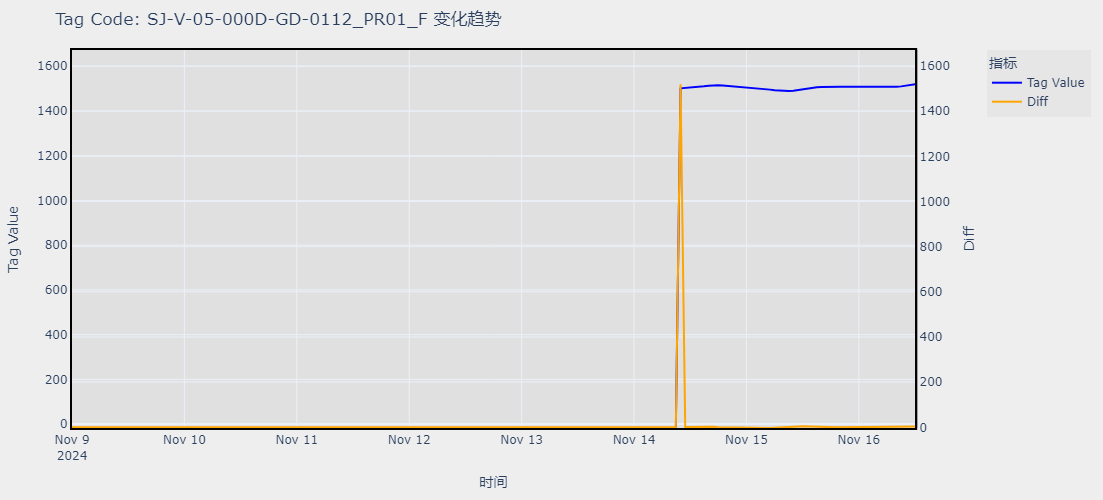

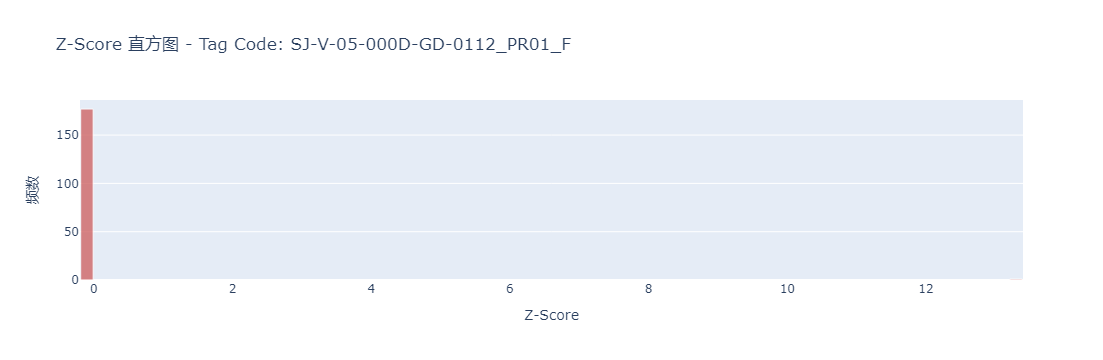

Tag Code: SJ-V-05-000D-GD-0119_PR04_F
平均值: -1.5324022346368715, 中位数: -1.6000000000000227, 标准差: 0.6181250575819167


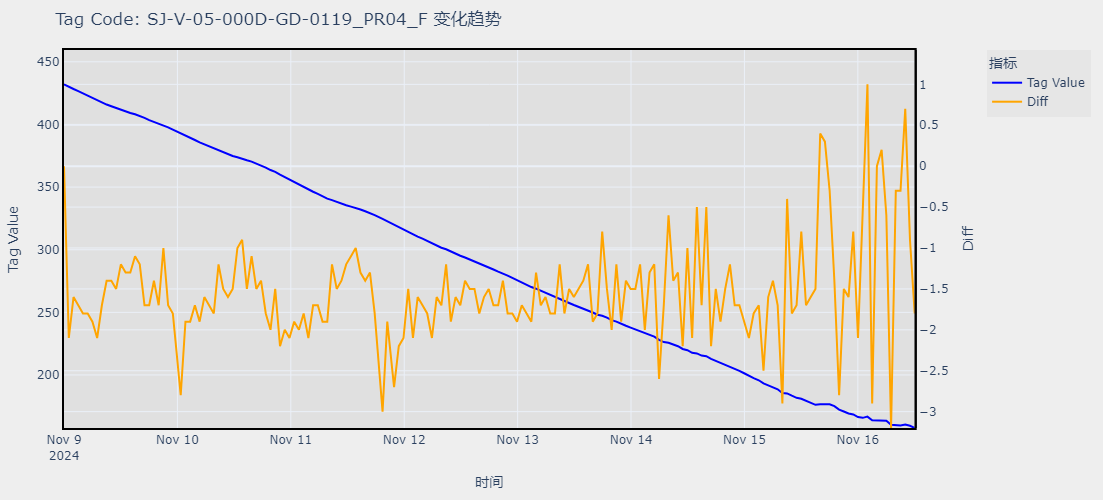

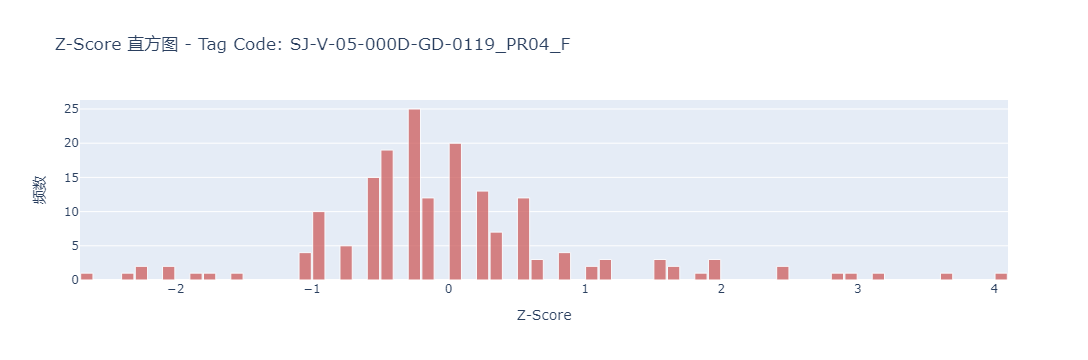

In [1]:
# from IPython.display import display, HTML
# display(HTML("<style>.container { width:2% !important; }</style>"))

# 让notebook宽屏显示
from IPython.display import display, HTML
display(HTML('<style>.container{width:100%!important;}</style>'))

import plotly.express as px
import numpy as np
import pandas as pd
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots  # 导入 make_subplots


# 下面这两行是使用jupyter notebook的时候，用于在notebook中显示图表的设置
import plotly.offline as py
py.init_notebook_mode(connected=True)

# %run 从api批量获取原始数据.py
# 从.pkl文件读取原始数据
result_df = pd.read_pickle('result_df.pkl')
print(result_df)

# 获取不重复的tagCode并存储在列表中
tag_codes = result_df['tagCode'].unique().tolist()

# 创建一个ExcelWriter对象
with pd.ExcelWriter('tag_code_analysis.xlsx') as writer:
    for tag_code in tag_codes:
        # 生成对应tagCode的数据框
        tag_df = result_df[result_df['tagCode'] == tag_code].copy()

        # 读取tagValue，新增一个diff列
        tag_df['diff'] = tag_df['tagValue'].diff().fillna(0).astype(float)

        # 计算z-score、平均值、中位数、标准差
        diff_without_first = tag_df['diff'][1:]
        z_scores = stats.zscore(diff_without_first)

        # 将Z-Score添加到DataFrame中
        tag_df['z_score'] = np.nan
        tag_df.loc[1:, 'z_score'] = z_scores

        mean_diff = np.mean(diff_without_first)
        median_diff = np.median(diff_without_first)
        std_dev_diff = np.std(diff_without_first)

        # 打印输出当前的dataframe及统计结果
        print(f"Tag Code: {tag_code}")
        print(f"平均值: {mean_diff}, 中位数: {median_diff}, 标准差: {std_dev_diff}")
        print("=" * 50)

        # 将当前tag_df写入Excel的对应sheet
        tag_df.to_excel(writer, sheet_name=str(tag_code), index=False)

        # 使用 Plotly 绘制趋势图
        fig_trend = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])  # 创建单个子图，带有副Y轴
        fig_trend.add_trace(go.Scatter(x=tag_df['time'], y=tag_df['tagValue'], mode='lines', name='Tag Value',
                                       line=dict(color='blue')), secondary_y=False)
        fig_trend.add_trace(go.Scatter(x=tag_df['time'], y=tag_df['diff'], mode='lines', name='Diff',
                                       line=dict(color='orange')), secondary_y=True)
        fig_trend.update_layout(
            title=f'Tag Code: {tag_code} 变化趋势',
            xaxis_title='时间',
            legend_title='指标',
            template='plotly_white',
            plot_bgcolor='rgba(224, 224, 224, 1)',
            paper_bgcolor='rgba(224, 224, 224, 0.5)',
            margin=dict(l=50, r=20, t=50, b=20),
            width=800,
            height=500,
            xaxis=dict(showline=True, linewidth=2, linecolor='black', mirror=True),
            yaxis=dict(showline=True, linewidth=2, linecolor='black', mirror=True),
            yaxis2=dict(showline=True, linewidth=2, linecolor='black', mirror=True)
        )
        fig_trend.update_yaxes(title_text="Tag Value", secondary_y=False)
        fig_trend.update_yaxes(title_text="Diff", secondary_y=True)
        max_tag_value = tag_df['tagValue'].max()
        min_tag_value = tag_df['tagValue'].min()
        padding_tag_value = 0.1 * (max_tag_value - min_tag_value)
        fig_trend.update_yaxes(range=[min_tag_value, max_tag_value + padding_tag_value], secondary_y=False)
        max_diff = tag_df['diff'].max()
        min_diff = tag_df['diff'].min()
        padding_diff = 0.1 * (max_diff - min_diff)
        fig_trend.update_yaxes(range=[min_diff, max_diff + padding_diff], secondary_y=True)

        # 显示趋势图
        fig_trend.show()

        # 绘制Z-Score的直方图
        fig_zscore = px.histogram(tag_df.dropna(subset=['z_score']), x='z_score', nbins=100,
                                  title=f'Z-Score 直方图 - Tag Code: {tag_code}',
                                  labels={'z_score': 'Z-Score'},
                                  opacity=0.75,
                                  color_discrete_sequence=['indianred'])
        fig_zscore.update_traces(marker_line_width=1, marker_line_color="white")
        fig_zscore.update_layout(bargap=0.1, xaxis_title='Z-Score', yaxis_title='频数')

        # 显示Z-Score直方图
        fig_zscore.show()